In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi  = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos  = {i:s for s,i in stoi.items()}
vocal_size = len(itos)

In [2]:
# building dataset

block_size =3

def build_dataset(words, block_size=3):
    X , Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            X.append(context)
            Y.append(stoi[ch])
            # print(f"{''.join([itos[i] for i in context])} -> {ch}") 

            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1], block_size=3)
Xdv, Ydv = build_dataset(words[n1:n2], block_size=3)
Xte, Yte = build_dataset(words[n2:], block_size=3)

print(Xtr.shape, Ytr.shape, Xdv.shape, Ydv.shape, Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625]) torch.Size([22655, 3]) torch.Size([22655]) torch.Size([22866, 3]) torch.Size([22866])


In [3]:
# building MLP with rand initialization

n_embd = 2
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g)
B1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn((n_hidden, vocal_size),                generator=g)
B2 = torch.randn(vocal_size,                            generator=g)

parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))

6881


In [4]:
batch_size = 32
steps = 200000
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
        

      0/ 200000:  20.9013
  10000/ 200000:  2.4572
  20000/ 200000:  3.0319
  30000/ 200000:  2.1121
  40000/ 200000:  2.2756
  50000/ 200000:  2.5564
  60000/ 200000:  2.0393
  70000/ 200000:  2.5573
  80000/ 200000:  2.3880
  90000/ 200000:  2.2627
 100000/ 200000:  2.4959
 110000/ 200000:  2.2784
 120000/ 200000:  2.1399
 130000/ 200000:  2.1660
 140000/ 200000:  2.2445
 150000/ 200000:  2.2071
 160000/ 200000:  2.1775
 170000/ 200000:  2.4813
 180000/ 200000:  2.2048
 190000/ 200000:  2.4795


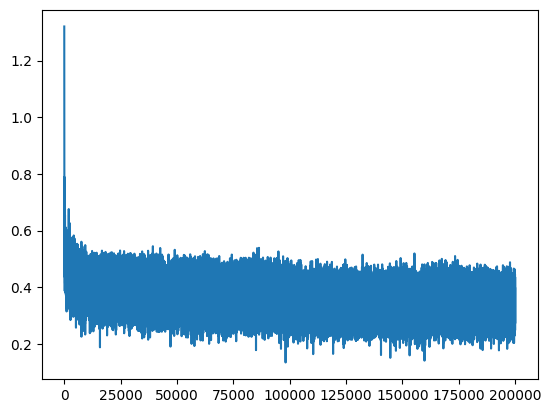

In [5]:
plt.plot(lossi)

In [6]:
torch.no_grad()
def print_overall_loss(split):
    x , y = {'train':(Xtr, Ytr), 'dev':(Xdv, Ydv), 'test':(Xte, Yte)}[split]
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

print_overall_loss('train')
print_overall_loss('dev')    

train loss: 2.2344
dev loss: 2.2411


In [7]:
# sampling from model
g = torch.Generator().manual_seed(2147483647 + 10) 

for i in range(10):
    out = ''
    context = [0] * block_size
    while True:
        x = torch.tensor([context])
        x_emb = C[x]
        h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
        h = torch.tanh(h1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        out += itos[ix]
        context = context[1:] + [ix]
        if ix == 0:
            print(f"{i} : {out}")
            break
        
        # predicted_char = itos[p]
        # out += predicted_char
        # if p == 0:
        #     print(f"{i} : {out}")
        #     break
        # context = context[1:] + [c]
        
    

0 : mora.
1 : kayanniellend.
2 : rylle.
3 : emmaniejerlee.
4 : aderedieliah.
5 : milopaleigh.
6 : estanaraelyzios.
7 : kalin.
8 : sher.
9 : rixhiriel.


# Optimization starting


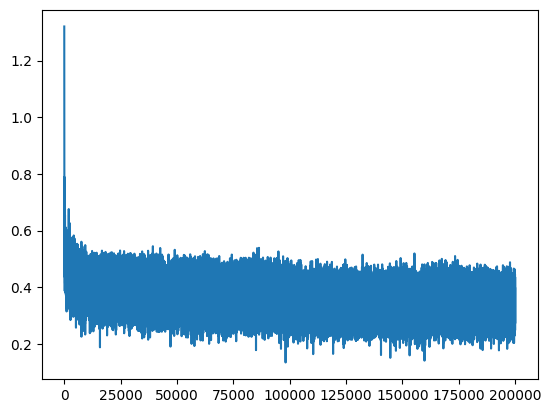

In [8]:
plt.plot(lossi)

# loss graph

We notice that the loss is very high in the starting few iterations and then remains within a range for the rest of the iterations.
From this we can infer that our initialization of weights is not optimum. 

how do u know what loss to expect at initialization?
we know number of class(n) in final outcome. so prob of any class is 1/n.
the loss is negative log of probability. ie -torch.tensor(1/n).log()
in our case we have 27 chars that can be outputs.
-torch.tensor(1/27).log() = 3.29 which is less than our initial loss of 18.2182

we can think that of this like predicting with high confidence while being wrong. 
this woudl happen if the logits are taking extreme values and creating face confidence. we ideally want logits to be close to zero at first.
we know logits are a function of W2 and B2

one way to do this is to initialize W2 to be very low and B2 to zero.

6881
      0/ 200000:  3.2975
  10000/ 200000:  1.7572
  20000/ 200000:  2.7875
  30000/ 200000:  2.1443
  40000/ 200000:  1.9920
  50000/ 200000:  2.5969
  60000/ 200000:  1.8504
  70000/ 200000:  2.3333
  80000/ 200000:  2.2600
  90000/ 200000:  2.2134
 100000/ 200000:  2.2034
 110000/ 200000:  2.3386
 120000/ 200000:  1.9836
 130000/ 200000:  1.9375
 140000/ 200000:  2.1215
 150000/ 200000:  2.1011
 160000/ 200000:  2.2936
 170000/ 200000:  2.3934
 180000/ 200000:  2.1745
 190000/ 200000:  2.3193


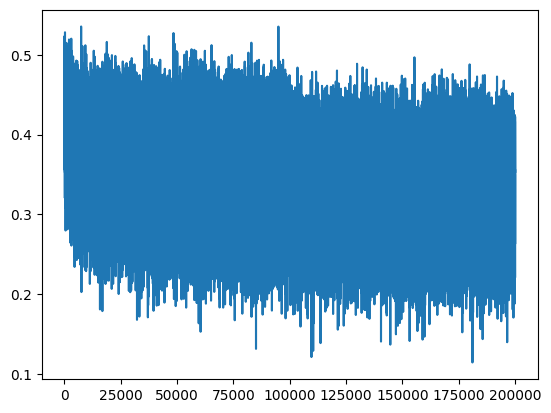

In [9]:
# building MLP with rand initialization

n_embd = 2
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g)
B1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn((n_hidden, vocal_size),                generator=g) * 0.01
B2 = torch.randn(vocal_size,                            generator=g) * 0

parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))


batch_size = 32
steps = 200000
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    # break
    
plt.plot(lossi)

Even though the initialization of W2 and B1 is better and loss we lower we still need to evaulate hidden state values are linearlity ie h.

h = torch.tanh(h1) 
ref formula: t = (math.exp(2*x)-1)/(math.exp(2*x)+1); tanh diff is (1-t**2)

here tanh we squash extreme negative and positive values to -1,1 and its gradient for these will effectively become 0.
so we can plot the values of h and see how many of them are in the extremes. ideally we want this to be low.


6881
      0/ 200000:  3.2975


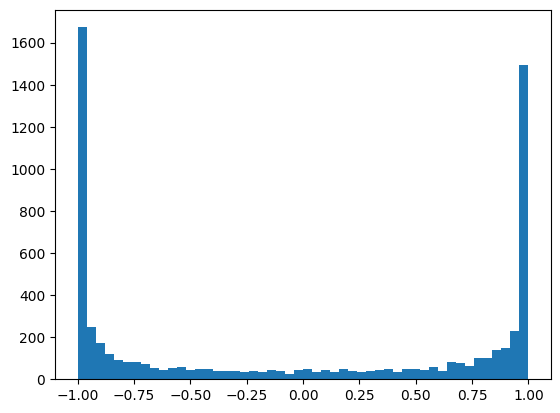

In [10]:
n_embd = 2
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g) 
B1 = torch.randn(n_hidden,                              generator=g) 
W2 = torch.randn((n_hidden, vocal_size),                generator=g) * 0.01
B2 = torch.randn(vocal_size,                            generator=g) * 0

parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))


batch_size = 32
steps = 200000
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    break

plt.hist(h.view(-1).tolist(), bins=50);

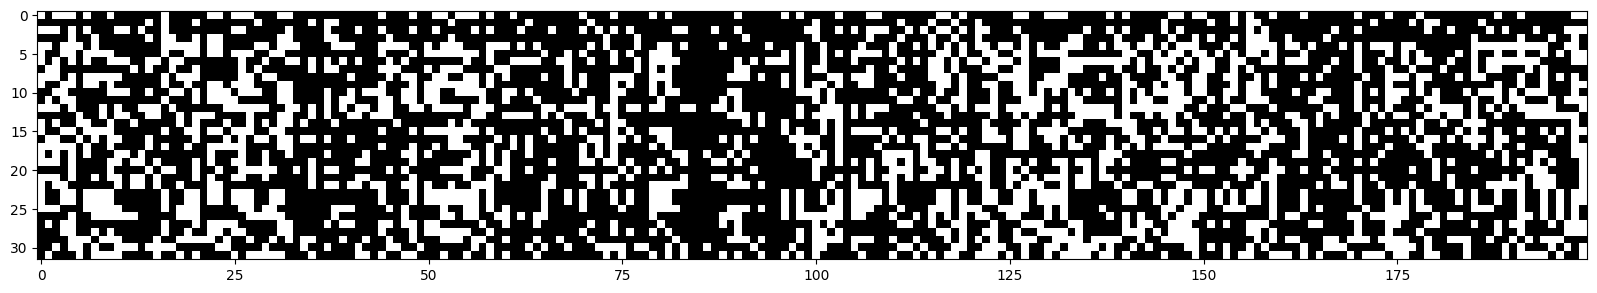

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

if any lines are completely white it would mean for all 32 examples the neurons didnt fire atall making it a dead neuron. (view vertically)

From above we can see that a large number of them are in extremeties. one way to fix this would be to ensure the values going into tanh are small ie h1.
we know h1 is dependent on W1 and B1 and we can make them small

we want this for all layers at inilization hence we multiple them with Kaiming He 

11897
      0/ 200000:  3.3179


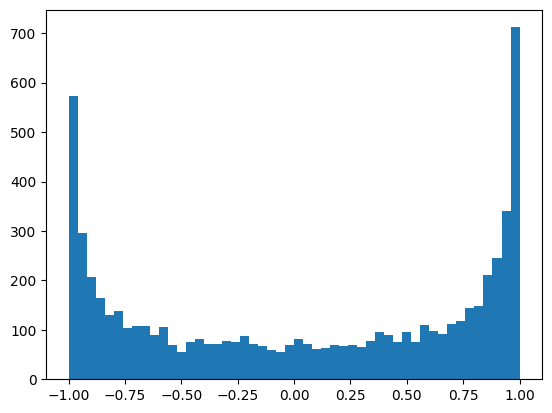

In [12]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g) * (5/3) / ((block_size * n_embd)**0.5) # 0.3
B1 = torch.randn(n_hidden,                              generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocal_size),                generator=g) * 0.01
B2 = torch.randn(vocal_size,                            generator=g) * 0

parameters = [C, W1, B1, W2, B2]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))


batch_size = 32
steps = 200000
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    break

plt.hist(h.view(-1).tolist(), bins=50);

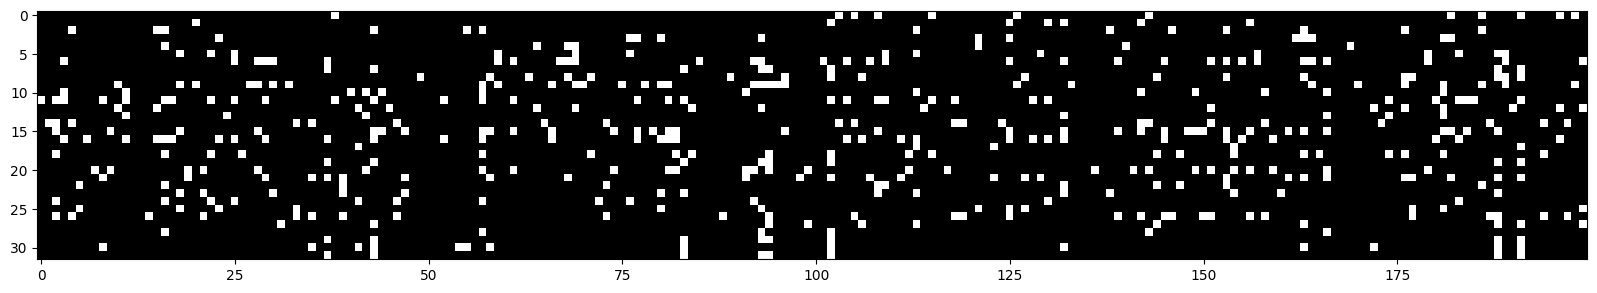

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Since for a large network we cannot determine what number to multiply so that the weights are uniformly distributed through linearlity and also their gradients are uniformly distributed. we can use emperically found data from kaiming he paper. 

so above instead of using a random 0.2 we not use * (5/3) / ((block_size * n_embd)**0.5) from kaiming initilization 
can also use torch.nn.init.kaiming_normal_

# Batch Normalization

for any fully connect layer in our case its h1 we calculate its mean and std and normalize. we do this to ensure h1 is normalized since that is designred for gradient descent.
we add gain and bias so the network can scale and shift as needed while the weights reamin normalized.
lastly we maintain a running mean and std to use at inference

In [14]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocal_size, n_embd ,                    generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g) * (5/3) / ((block_size * n_embd)**0.5) # 0.3
# B1 = torch.randn(n_hidden,                              generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocal_size),                generator=g) * 0.01
B2 = torch.randn(vocal_size,                            generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running  = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, B2, bngain, bnbias]

for p in parameters:
    p.requires_grad_()

print(sum(p.nelement() for p in parameters))


batch_size = 32
steps = 200000
momentum = 0.001
lossi = []


for i in range(steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 #+ B1
    
    # batch norm
    bnmeani = h1.mean(dim=0, keepdim=True)
    bnstdi = h1.std(dim=0, keepdim=True)
    h1 = bngain * (h1 - bnmeani) / (bnstdi + bnbias)
    # update running bn params
    with torch.no_grad():
        bnmean_running = momentum * bnmean_running + (1 - momentum) * bnmeani
        bnstd_running = momentum * bnstd_running + (1 - momentum) * bnstdi
    
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
        
        
torch.no_grad()
def print_overall_loss(split):
    x , y = {'train':(Xtr, Ytr), 'dev':(Xdv, Ydv), 'test':(Xte, Yte)}[split]
    x_emb = C[x]
    h1 = x_emb.view(x_emb.shape[0],-1) @ W1 + B1
    h1 = bngain * (h1 - bnmean_running) / (bnstd_running + bnbias)
    h = torch.tanh(h1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

print_overall_loss('train')
print_overall_loss('dev')    


12097
      0/ 200000:  3.3239
  10000/ 200000:  2.0466
  20000/ 200000:  2.5298
  30000/ 200000:  2.0176
  40000/ 200000:  2.2863
  50000/ 200000:  1.8578
  60000/ 200000:  2.0697
  70000/ 200000:  2.3031
  80000/ 200000:  2.4424
  90000/ 200000:  2.1017
 100000/ 200000:  2.2757
 110000/ 200000:  2.2875
 120000/ 200000:  1.6523
 130000/ 200000:  1.9718
 140000/ 200000:  2.2781
 150000/ 200000:  1.9818
 160000/ 200000:  2.1559
 170000/ 200000:  2.4214
 180000/ 200000:  2.1220
 190000/ 200000:  2.1372
train loss: 2.1008
dev loss: 2.1363


# converting code to pytorch API

In [34]:
g = torch.Generator().manual_seed(2147483647) 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),  generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.std(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocal_size, n_embd), generator=g) # the character embedding matrix
Layers = [
    Linear((n_embd * block_size), n_hidden),        Tanh(),             # first hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, vocal_size)                                        # the output layer of the MLP
]        

with torch.no_grad():
    # we are making the probs of last layer small to lower confidence / lower loss. any deep untrained network may output random higher probs so to comp for that. this happens irrespective of kaiming initialization.
    Layers[-1].weight *= 0.1

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True

Total number of parameters: 46497


In [35]:
steps=200000
batch_size=32
lossi = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    x_emb = C[xb]
    x = x_emb.view(x_emb.shape[0], -1)
    
    for layer in Layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    break

      0/ 200000:  3.2986


Now we plot the histogram of the forward pass activations at each layer.
from the plot we roughly want std to be 0.65 for layers and saturation to be around 5%. this happens when we use kaiming init (5/3 for tanh)


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

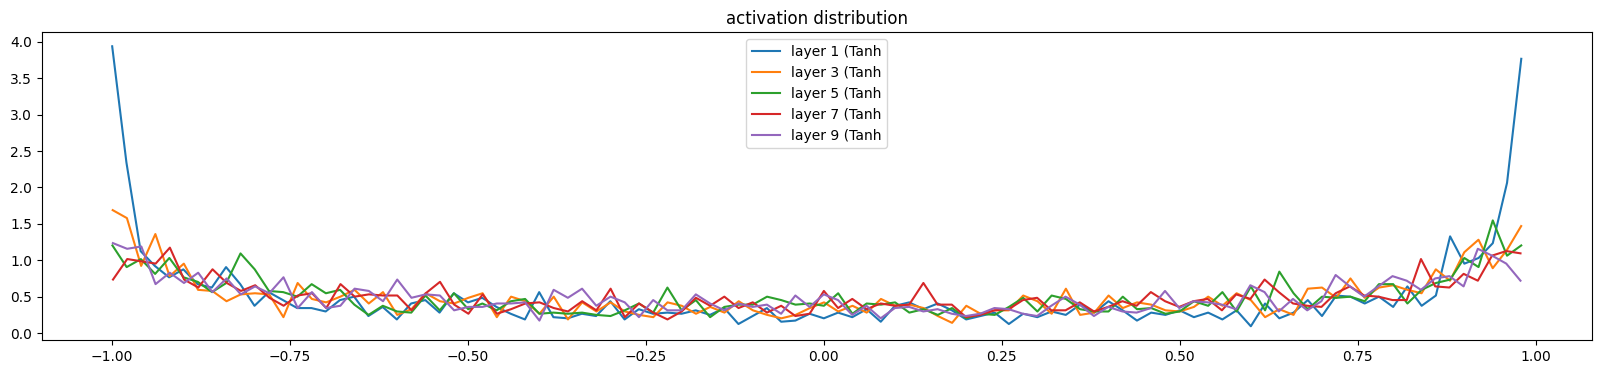

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

If we initialize the weights of the network with small random values, the activations of the hidden layers will be small, and the network will not be able to learn. this happens because tanh at every layer will be a squashing function so it'll keep on reducing the std and making it narrower. this will lead to lower grad values and slower learning. therefore we need some gain, an in our case we use 5/3 based on kaiming init for tanh. this flights against the squashing of weights/grads and ensures we can learn faster. 


if we multiply with a large number instead of 5/3. something like 3 we will see std go up and more importantly saturation go up. this would imply that the gradients are not flowing back in the network properly/ large chucks of the network isnt learning properly. hence we need a optimum gain factor to ensure the network doesnt get too saturated or too sqashed. 

Total number of parameters: 46497
      0/ 200000:  3.2694
layer 1 (      Tanh): mean -0.03, std 0.85, saturated: 47.66%
layer 3 (      Tanh): mean +0.00, std 0.84, saturated: 40.47%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 42.38%
layer 7 (      Tanh): mean -0.01, std 0.84, saturated: 42.00%
layer 9 (      Tanh): mean -0.03, std 0.84, saturated: 42.41%


Text(0.5, 1.0, 'activation distribution')

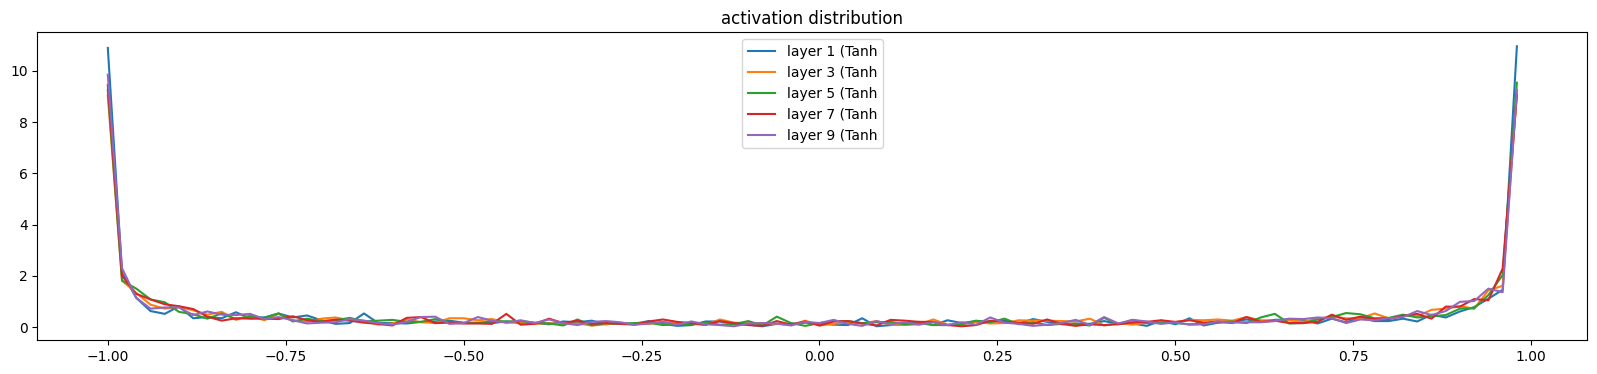

In [37]:
g = torch.Generator().manual_seed(2147483647) 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),  generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.std(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocal_size, n_embd), generator=g) # the character embedding matrix
Layers = [
    Linear((n_embd * block_size), n_hidden),        Tanh(),             # first hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, vocal_size)                                        # the output layer of the MLP
]        

with torch.no_grad():
    # we are making the probs of last layer small to lower confidence / lower loss. any deep untrained network may output random higher probs so to comp for that. this happens irrespective of kaiming initialization.
    Layers[-1].weight *= 0.1

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= 3 #(5/3)
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True
    
steps=200000
batch_size=32
lossi = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    x_emb = C[xb]
    x = x_emb.view(x_emb.shape[0], -1)
    
    for layer in Layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    break

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

similar to above we can also plot the gradients of the tanh layers.
the main thing to infer here is that when you compare the graph of all layers, they are similar to one another. we dont want a few of them to be shrinking or exploding

change the following lines to see the graph change:

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 #(5/3) # 3

Total number of parameters: 46497
      0/ 200000:  3.2959
layer 1 (      Tanh): mean +0.000000, std 9.461796e-06
layer 3 (      Tanh): mean -0.000000, std 1.971722e-05
layer 5 (      Tanh): mean +0.000002, std 4.017593e-05
layer 7 (      Tanh): mean +0.000005, std 7.805648e-05
layer 9 (      Tanh): mean -0.000007, std 1.526739e-04


Text(0.5, 1.0, 'gradient distribution')

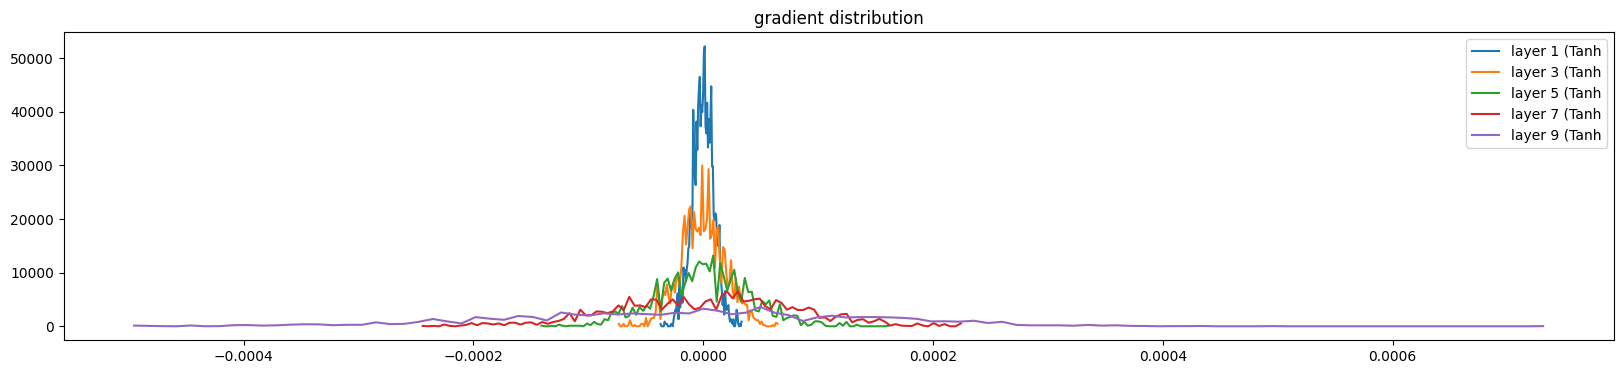

In [44]:
g = torch.Generator().manual_seed(2147483647) 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),  generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.std(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocal_size, n_embd), generator=g) # the character embedding matrix
Layers = [
    Linear((n_embd * block_size), n_hidden),        Tanh(),             # first hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, vocal_size)                                        # the output layer of the MLP
]        

with torch.no_grad():
    # we are making the probs of last layer small to lower confidence / lower loss. any deep untrained network may output random higher probs so to comp for that. this happens irrespective of kaiming initialization.
    Layers[-1].weight *= 0.1

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 #(5/3)
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True
    
steps=200000
batch_size=32
lossi = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    x_emb = C[xb]
    x = x_emb.view(x_emb.shape[0], -1)
    
    for layer in Layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in Layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    break

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

we esentailly want weights and grad to have symmetry. the bigger the network and if we have asymmetry it wont train well.

If we remove all tanh activations and stack only linear layers, the entire forward pass effectively collapses into a single linear transformation: x @ W + b. The tanh non-linearities are essential because they allow the network to approximate any arbitrary function, rather than being limited to just linear transformations.

another important plot we want is what was the update in each step compared to the data. 
we can do this by logging ud like showing below and then plot it. 1e -3 or 0.001 is where we want the plot of each layer of weights to be.
if plot for each layer is below the line then learning is happening very slowly. can check using a low LR.
if plot for each layer is higher then than line by few magnitudes then lr is very high. 

Total number of parameters: 46497
      0/ 200000:  3.2986


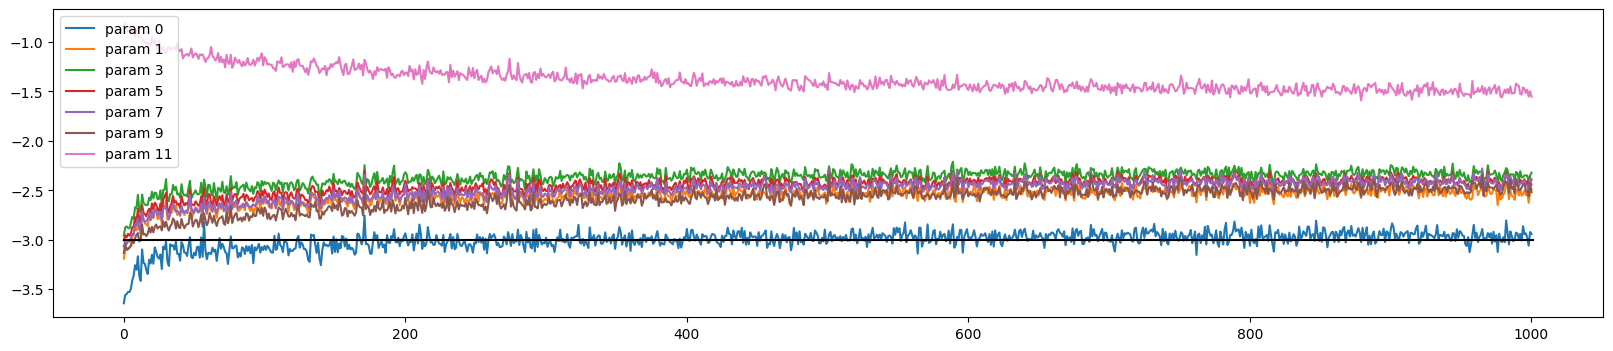

In [51]:
g = torch.Generator().manual_seed(2147483647) 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),  generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.std(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocal_size, n_embd), generator=g) # the character embedding matrix
Layers = [
    Linear((n_embd * block_size), n_hidden),        Tanh(),             # first hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, vocal_size)                                        # the output layer of the MLP
]        

with torch.no_grad():
    # we are making the probs of last layer small to lower confidence / lower loss. any deep untrained network may output random higher probs so to comp for that. this happens irrespective of kaiming initialization.
    Layers[-1].weight *= 0.1

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) # 0.5 # 3
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True
    
steps=200000
batch_size=32
lossi = []
ud = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    x_emb = C[xb]
    x = x_emb.view(x_emb.shape[0], -1)
    
    for layer in Layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in Layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    if i >= 1000:
        break 



plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

in the above case the last layer ie link line is well above 1e -3 because we lowered the confidence of lasy layer to be very low manually.


using above plots we can address any issue with calibration of our model.

Batchnorm precisely solve for above issues of precise initialization. 
we can simply check this if we add batchnorm between linear layers and tanh

Total number of parameters: 46497
      0/ 200000:  3.2959


  10000/ 200000:  2.3606
layer 1 (      Tanh): mean -0.01, std 0.63, saturated: 6.38%
layer 3 (      Tanh): mean -0.01, std 0.57, saturated: 2.09%
layer 5 (      Tanh): mean +0.01, std 0.58, saturated: 2.19%
layer 7 (      Tanh): mean -0.00, std 0.57, saturated: 4.31%
layer 9 (      Tanh): mean -0.01, std 0.49, saturated: 4.56%
layer 1 (      Tanh): mean -0.000099, std 2.616824e-03
layer 3 (      Tanh): mean +0.000097, std 1.882714e-03
layer 5 (      Tanh): mean +0.000021, std 1.753612e-03
layer 7 (      Tanh): mean -0.000023, std 2.168287e-03
layer 9 (      Tanh): mean +0.000081, std 3.142977e-03


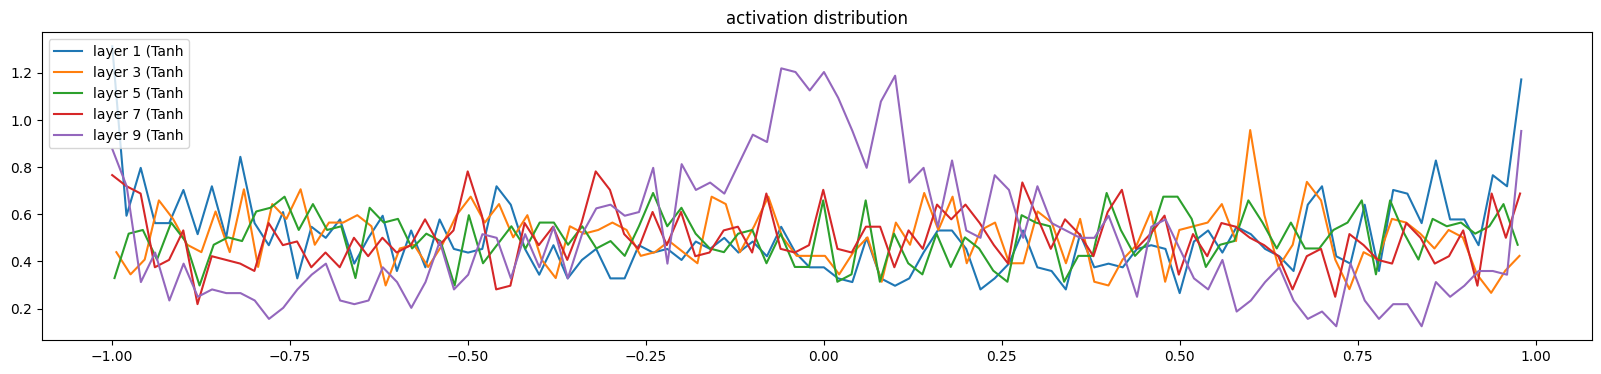

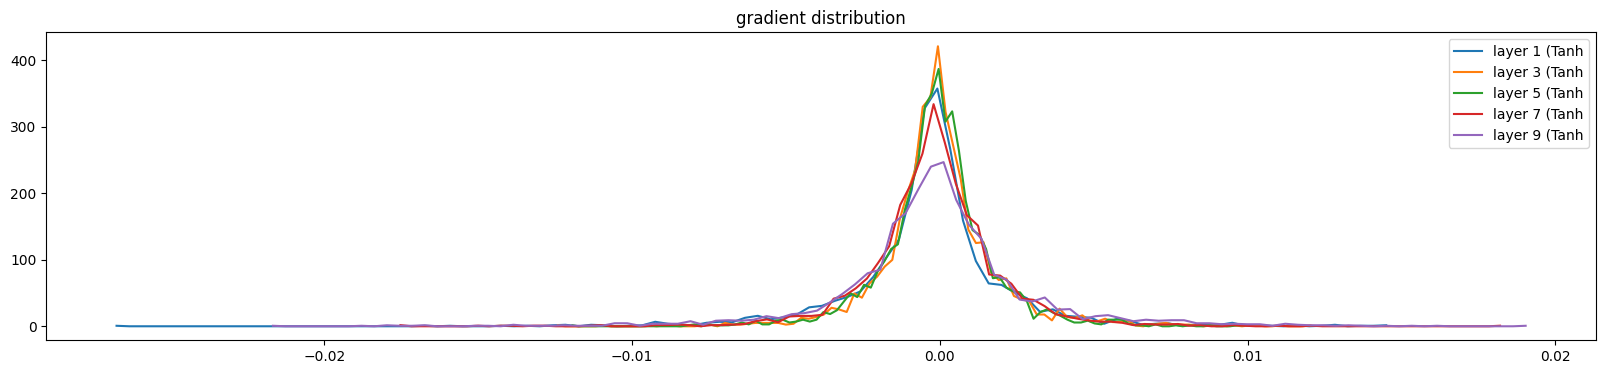

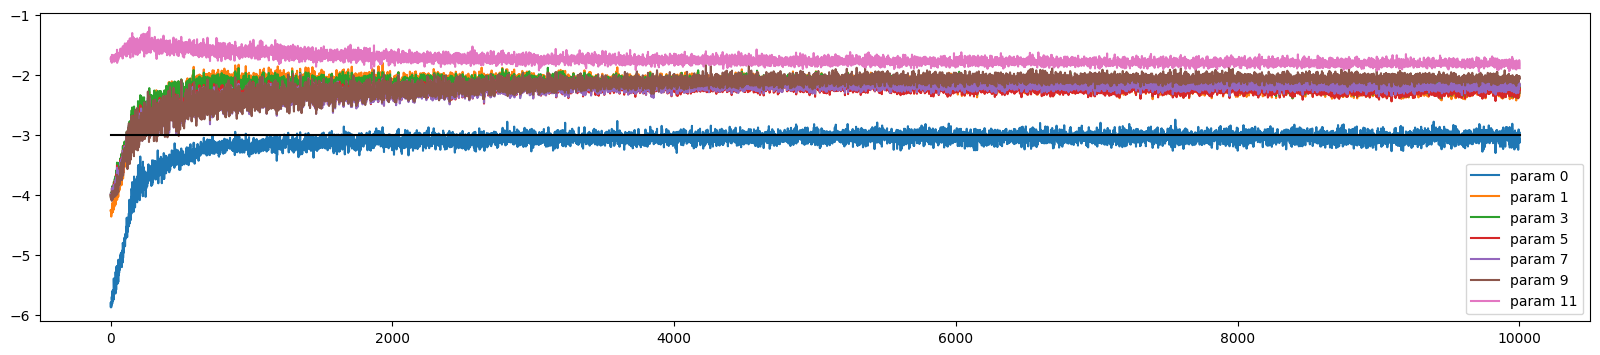

In [52]:
g = torch.Generator().manual_seed(2147483647) 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out),  generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.std(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocal_size, n_embd), generator=g) # the character embedding matrix
Layers = [
    Linear((n_embd * block_size), n_hidden),        Tanh(),             # first hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, n_hidden),                     Tanh(),             # second hidden layer
    Linear(n_hidden, vocal_size)                                        # the output layer of the MLP
]        

with torch.no_grad():
    # we are making the probs of last layer small to lower confidence / lower loss. any deep untrained network may output random higher probs so to comp for that. this happens irrespective of kaiming initialization.
    Layers[-1].weight *= 0.1

    # applying gain to linear layers
    for layer in Layers:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 #(5/3)
            
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True
    
steps=200000
batch_size=32
lossi = []
ud = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    x_emb = C[xb]
    x = x_emb.view(x_emb.shape[0], -1)
    
    for layer in Layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    # backward pass
    for layer in Layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    if i > 10000: 
        break

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

now we are less susceptible to kaiming initialization go weights. we can run the above without 5/3 or diving by sqrt(fan_in) and still get a good plot due to batchnorm. 